
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from fgbuster import CMB, Dust, Synchrotron, MixingMatrix
from fgbuster.observation_helpers import standardize_instrument, get_observation
from fgbuster.cosmology import _get_Cl_cmb, _get_Cl_noise
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import healpy as hp
import numdifftools as nd
import math as m
from fgbuster.algebra import  W_dBdB, W_dB, W, _mmm, _utmv, _mmv


In [76]:
instr = np.load('/Users/alicepirotta/Desktop/APC/MCMC/instrument_LB_IMOv1.npy', allow_pickle=True).item()
instr_ = {}
instr_['frequency'] = np.array([instr[f]['freq'] for f in instr.keys()])
instr_['depth_p'] = np.array([instr[f]['P_sens'] for f in instr.keys()])
instr_['fwhm'] = np.array([instr[f]['beam'] for f in instr.keys()])
instr_['depth_i'] = instr_['depth_p']/np.sqrt(2)
instrument = standardize_instrument(instr_)

In [77]:
nside = 64
freq_maps_N = get_observation(instrument, 'd0s0', noise=True, nside=nside)[:,1:,:]
freq_maps = get_observation(instrument, 'd0s0', noise=False, nside=nside)[:,1:,:]
n_freq=22

In [78]:
components= [CMB(), Dust(50.), Synchrotron(50.)]

In [79]:
A = MixingMatrix(*components)
A_ev = A.evaluator(instrument.frequency)
A_dB_ev = A.diff_evaluator(instrument.frequency)
N = np.eye(len(instrument.frequency)) 
invN = np.diag((hp.nside2resol(nside, arcmin=True) / instrument.depth_p)**2)

In [80]:

x1 = np.array([1.3,19,-2.5, 0.8,1.3])

In [81]:
# Cl_all_g = []
# seeds = 10
# for i in range (seeds):
#     np.random.seed(i)
    

#     def spectral_likelihood(y):
#         Bd, T, Bs, a, c = y
#         b = 1
#         G = np.diag([a,a,a,a,a,a,a,b,b,b,b,b,b,b,b,c,c,c,c,c,c,c])
#         invNd = np.einsum('ij,jsp->isp', invN, freq_maps_N)
#         A_maxL =G.dot(A_ev(np.array([Bd,T,Bs]))) 
#         logL = 0
#         AtNd= np.einsum('ji,jsp->isp', A_maxL, invNd)
#         AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
#         logL = logL + np.einsum('isp,ij,jsp->', AtNd, AtNA, AtNd)
#         if logL != logL:
#             return 0.0
#         return -logL

#     min_= minimize (spectral_likelihood, x1, method='Nelder-Mead')
  
 
#     a = min_.x[3]
#     b= 1
#     c = min_.x[4]
#     G = np.diag([a,a,a,a,a,a,a,b,b,b,b,b,b,b,b,c,c,c,c,c,c,c])  
#     invNd = np.einsum('ij,jsp->isp', invN, freq_maps_N)
#     A_maxL =G.dot(A_ev(min_.x)) 

#     AtNd= np.einsum('ji,jsp->isp', A_maxL, invNd)
#     AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
#     print(AtNA.shape)
#     print(AtNd.shape)


#     s = np.einsum('cg,gsp->csp', AtNA,AtNd)
#     s = s[0]
#     zeros=np.zeros((1, 49152))
#     unione = np.vstack((zeros, s))
    
    
#     Cl =hp.anafast(unione)[2,2:]
#     Cl_all_g.append(Cl)
 

# Cl_all_g=np.array(Cl_all_g)
# Cl_mean_g=np.mean(Cl_all_g, axis=0) 
# Cl_std_g = np.std(Cl_all_g, axis=0)



# ell = np.arange(2,192)
# Dl_mean_g = (ell*(ell+1)*Cl_mean_g)/(2*m.pi)
# Dl_std_g = (ell*(ell+1)*Cl_std_g)/(2*m.pi)




# Cl_BB_r1 = _get_Cl_cmb(Alens=0.0, r=1.)[2][2:192]
# Cl_BB_r001 = _get_Cl_cmb(Alens=0.0, r=0.001)[2][2:192]
# Dl_BB = (ell*(ell+1)*Cl_BB_r001)/(2*m.pi)

# Cl_lens = _get_Cl_cmb(Alens=1.0, r=0.)[2][2:192]
# Dl_lens = (ell*(ell+1)*Cl_lens)/(2*m.pi)

# Data_g = Cl_mean_g + Cl_lens
# fsky = 1
# F_g = np.sum((2*ell+1) * fsky / 2*Cl_BB_r1** 2 / Data_g ** 2)
# sigma_r_fisher_g = np.sqrt(1.0 / F_g)
# print(F_g)
# print(sigma_r_fisher_g)





# plt.loglog(ell, Dl_mean_g, label = "Dl_BB_g")
# plt.loglog(ell, Dl_lens, label = "Dl_lensing_g")
# plt.loglog(ell, Dl_BB, label = "Dl_BB_r0.001_g")
# plt.fill_between(ell,Dl_mean_g+Dl_std_g, Dl_mean_g-Dl_std_g, alpha=0.2, label="Dl_BB_std_g")



# plt.xlabel(r'$\ell$')
# plt.ylabel(r'$\ell$* ($\ell$+1)*C$\ell$/2$\pi$')
# plt.legend()


In [82]:
dati = np.einsum('ijp,klp-> ijkl',freq_maps,freq_maps)
print(dati.shape)


(22, 2, 22, 2)


(2, 49152)
(190,)
838025028.8295424
3.454391092918724e-05


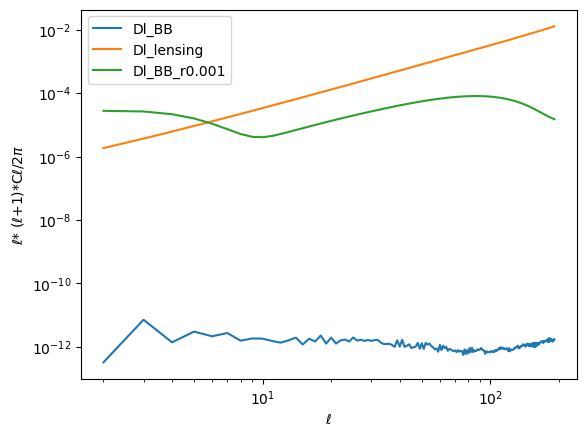

In [83]:

def aver_likelihood(y):
    Bd, T, Bs, a, c = y
    b= 1
    G = np.diag([a, a, a, a, a, a, a, a, b, b, b, b, b, b, c, c, c, c, c, c, c, c ])
    A_maxL =G.dot(A_ev(np.array([Bd,T,Bs]))) 
    logL = 0
    AtN = A_maxL.T.dot(invN)
    NA= invN.dot(A_maxL)
    AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
    P = NA.dot(AtNA).dot(AtN)
    logL = logL -np.trace(np.einsum('fg, gikj->fk', P, dati)+np.einsum('fg, ij->gi', P, N))

    if logL != logL:
        return 0.0
    return logL

min_= minimize (aver_likelihood, x1, method='Nelder-Mead')
   
    
      
A_maxL =A_ev(min_.x) 
AtN = A_maxL.T.dot(N)
AtNA = np.linalg.inv(A_maxL.T.dot(N).dot(A_maxL))

s = np.einsum('cg,gs,sij->cij',AtNA,AtN,freq_maps)
s = s[0]
print(s.shape)
 
zeros=np.zeros((1, 49152))
unione = np.vstack((zeros, s))
        
   
    
Cl =hp.anafast(unione)[2,2:] 
print(Cl.shape)  
 


ell = np.arange(2,192)
Dl_mean = (ell*(ell+1)*Cl)/(2*m.pi)



Cl_BB_r1 = _get_Cl_cmb(Alens=0.0, r=1.)[2][2:192]
Cl_BB_r_001 = _get_Cl_cmb(Alens=0.0, r=0.001)[2][2:192]
Dl_BB = (ell*(ell+1)*Cl_BB_r_001)/(2*m.pi)

Cl_lens = _get_Cl_cmb(Alens=1.0, r=0.)[2][2:192]
Dl_lens = (ell*(ell+1)*Cl_lens)/(2*m.pi)


Data = Cl + Cl_lens
fsky = 1
F = np.sum((2*ell+1) * fsky / 2*Cl_BB_r1** 2 / Data ** 2)
sigma_r_fisher = np.sqrt(1.0 / F)
print(F)
print(sigma_r_fisher)



plt.loglog(ell, Dl_mean, label = "Dl_BB")
plt.loglog(ell, Dl_lens, label = "Dl_lensing")
plt.loglog(ell, Dl_BB, label = "Dl_BB_r0.001")




plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell$* ($\ell$+1)*C$\ell$/2$\pi$')
plt.legend()



    


In [84]:
lmax=192
lmin=2
A_dB_maxL = A_dB_ev(s)
A_dBdB_maxL = A.diff_diff_evaluator(instrument.frequency)(s)
Cl_fgs = np.zeros((n_freq, n_freq, lmax+1), dtype=freq_maps.dtype)
Cl_noise = _get_Cl_noise(instrument, A_maxL, lmax)[0, 0, lmin:]

W_maxL = W(A_maxL, invN=invN)[0, :]
W_dB_maxL = W_dB(A_maxL, A_dB_maxL, A.comp_of_dB, invN=invN)[:, 0]
W_dBdB_maxL = W_dBdB(A_maxL, A_dB_maxL, A_dBdB_maxL,
                         A.comp_of_dB, invN=invN)[:, :, 0]
V_maxL = np.einsum('ij,ij...->...', s.Sigma, W_dBdB_maxL)


#I put here on the top the things that I need to define. I change all the res with s. What is Sigma?

# Check dimentions
assert ((n_freq,) == W_maxL.shape == W_dB_maxL.shape[1:]
                       == W_dBdB_maxL.shape[2:] == V_maxL.shape)
assert (len(A.params) == W_dB_maxL.shape[0] 
                            == W_dBdB_maxL.shape[0] == W_dBdB_maxL.shape[1])

# elementary quantities defined in Stompor, Errard, Poletti (2016)
Cl_xF = {}
Cl_xF['yy'] = _utmv(W_maxL, Cl_fgs.T, W_maxL)  # (ell,)
Cl_xF['YY'] = _mmm(W_dB_maxL, Cl_fgs.T, W_dB_maxL.T)  # (ell, param, param)
Cl_xF['yz'] = _utmv(W_maxL, Cl_fgs.T, V_maxL )  # (ell,)
Cl_xF['Yy'] = _mmv(W_dB_maxL, Cl_fgs.T, W_maxL)  # (ell, param)
Cl_xF['Yz'] = _mmv(W_dB_maxL, Cl_fgs.T, V_maxL)  # (ell, param)

# bias and statistical foregrounds residuals
s.noise = Cl_noise
s.bias = Cl_xF['yy'] + 2 * Cl_xF['yz']  # S16, Eq 23
s.stat = np.einsum('ij, lij -> l', s.Sigma, Cl_xF['YY'])  # E11, Eq. 12
s.var = s.stat**2 + 2 * np.einsum('li, ij, lj -> l', # S16, Eq. 28
                                          Cl_xF['Yy'], s.Sigma, Cl_xF['Yy'])

AttributeError: 'numpy.ndarray' object has no attribute 'Sigma'